<h1 style="font-family:Impact,Arial;font-size:50px;">Proximity &amp; Neighbourhood:</h1>
<h2 style="font-family:Arial;">Using Topic Modelling To Read The Development Of Law In The High Court Of Australia</h2>

<p>This notebook serves as a technical appendix to the article by <a href="mailto:David.Carter@uts.edu.au?Subject=Proximity" target="_blank">
<small><font color=MediumVioletRed>David J Carter</font></small></a>  &amp; <a href="mailto:Adel.Rahmani@uts.edu.au?Subject=Proximity" target="_blank">
<small><font color=MediumVioletRed>Adel Rahmani</font></small></a> to appear in the Monash University Law Review.</p>

<p>The goal of this notebook is to provide addition information about certain concepts and ideas which we could not develop in the article due to space constraints. 
It also allows us to provide high-resolutions,  colour versions of the figures presented in the article.<p>

<b>Abstract:</b>
<blockquote cite="">
There is significant interest in the computational analysis of legal text to enhance search capabilities, to navigate the ever-growing corpus of electronic legal texts, and to aid in the application of artificial intelligence approaches to legal work and analysis. However, the feasibility of utilising this technique to trace the emergence and evolution of particular legal doctrines or substantive areas of law over time has not been achieved so far, despite the centrality of this task to legal practice and the use of legal text. Here, we report on the application of computational methods, including topic modelling and visualisation techniques, to measure the emergence and development of particular doctrines or areas of substantive law. We do so using two case studies, firstly the Mabo Litigation regarding native title, and the rise and fall of ‘proximity’ as a test of foreseeability and the duty of care in tort.</blockquote>

<hr style="height:5px;border:none;color:#333;background-color:#333;" />


In [1]:
# Import required modules

# manipulation of tabular data
import pandas as pd
import numpy as np

# text processing
import string
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from itertools import chain

# dimensionality reduction
from umap import UMAP

# hierarchical clustering
from scipy.cluster.hierarchy import dendrogram, linkage, set_link_color_palette  
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.cluster import AgglomerativeClustering

# visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import seaborn as sns
%matplotlib inline

# silence some warnings
import warnings
warnings.simplefilter('ignore')

# 1. Bag of words representation: Who is my neighbour?

Before any computation can be performed on a corpus of documents, it must be transformed into a numerical form.
This can be accomplished with a bag-of-words (BOW) representation, whereby each document is replaced by the count of how many times each word (or token) appears in the document. 

This is best illustrated on a simple example. Since we are concerned the legal doctrine of <em>proximity</em> (duty of care) let us consider the parable of the Good Samaritan found in The Bible in the book of Luke (<a href="https://www.biblegateway.com/passage/?search=Luke%2010:25-37&version=ESVUK">Luke 10:25-37</a>).

We will treat this passage as our corpus of documents; each verse constituting a "document".

Let's illustrate the various steps that lead to a term frequency inverse document frequency (TFIDF) representation of the corpus.

In [2]:
text = """
And behold, a lawyer stood up to put him to the test, saying, "Teacher, what shall I do to inherit eternal life?"
He said to him, "What is written in the Law? How do you read it?"
And he answered, "You shall love the Lord your God with all your heart and with all your soul and with all your strength and with all your mind, and your neighbour as yourself."
And he said to him, "You have answered correctly; do this, and you will live."
But he, desiring to justify himself, said to Jesus, "And who is my neighbour?"
Jesus replied, "A man was going down from Jerusalem to Jericho, and he fell among robbers, who stripped him and beat him and departed, leaving him half dead.
Now by chance a priest was going down that road, and when he saw him he passed by on the other side.
So likewise a Levite, when he came to the place and saw him, passed by on the other side.
But a Samaritan, as he journeyed, came to where he was, and when he saw him, he had compassion.
He went to him and bound up his wounds, pouring on oil and wine. Then he set him on his own animal and brought him to an inn and took care of him.
And the next day he took out two denarii and gave them to the innkeeper, saying, 'Take care of him, and whatever more you spend, I will repay you when I come back.'
Which of these three, do you think, proved to be a neighbour to the man who fell among the robbers?"
He said, "The one who showed him mercy." And Jesus said to him, 'You go, and do likewise.'
"""

We create a list of 13 documents, which we call `corpus`, by spliting the passage into verses. 

We also preprocess the text in the process by removing punctuation symbols and converting the text to lowercase.

In [3]:
corpus = ["".join([character for character in item.lower() 
                   if character in string.ascii_lowercase+' '])
          for item in text.splitlines() if item]
corpus

['and behold a lawyer stood up to put him to the test saying teacher what shall i do to inherit eternal life',
 'he said to him what is written in the law how do you read it',
 'and he answered you shall love the lord your god with all your heart and with all your soul and with all your strength and with all your mind and your neighbour as yourself',
 'and he said to him you have answered correctly do this and you will live',
 'but he desiring to justify himself said to jesus and who is my neighbour',
 'jesus replied a man was going down from jerusalem to jericho and he fell among robbers who stripped him and beat him and departed leaving him half dead',
 'now by chance a priest was going down that road and when he saw him he passed by on the other side',
 'so likewise a levite when he came to the place and saw him passed by on the other side',
 'but a samaritan as he journeyed came to where he was and when he saw him he had compassion',
 'he went to him and bound up his wounds pouring

Now that we have a collection of documents we can count how many times each word appears in each document. 
We are effectively replacing the words by numbers (their counts).

It is common to exclude the most common words of the language (called stopwords) during that process. The general idea is that the presence of common words such as "the" or "and" does not tell us much about what the document is about. It is also common to exclude words which appear in too few documents, as these tend to not be very informative
about the overall corpus.

Because we are dealing with a tiny, toy example, we'll simply filter out word which appear only once in our corpus.

The remaining words are the vocabulary for our corpus. If we count how many time each word of the vocabulary appears in each document, we can build a document to word matrix.

As for our stopwords, we can use the set of [English stopwords](https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/feature_extraction/stop_words.py) found in [scikit-learn](http://scikit-learn.org/stable/index.html).

In [4]:
ENGLISH_STOP_WORDS = frozenset([
    "a", "about", "above", "across", "after", "afterwards", "again", "against",
    "all", "almost", "alone", "along", "already", "also", "although", "always",
    "am", "among", "amongst", "amoungst", "amount", "an", "and", "another",
    "any", "anyhow", "anyone", "anything", "anyway", "anywhere", "are",
    "around", "as", "at", "back", "be", "became", "because", "become",
    "becomes", "becoming", "been", "before", "beforehand", "behind", "being",
    "below", "beside", "besides", "between", "beyond", "bill", "both",
    "bottom", "but", "by", "call", "can", "cannot", "cant", "co", "con",
    "could", "couldnt", "cry", "de", "describe", "detail", "do", "done",
    "down", "due", "during", "each", "eg", "eight", "either", "eleven", "else",
    "elsewhere", "empty", "enough", "etc", "even", "ever", "every", "everyone",
    "everything", "everywhere", "except", "few", "fifteen", "fifty", "fill",
    "find", "fire", "first", "five", "for", "former", "formerly", "forty",
    "found", "four", "from", "front", "full", "further", "get", "give", "go",
    "had", "has", "hasnt", "have", "he", "hence", "her", "here", "hereafter",
    "hereby", "herein", "hereupon", "hers", "herself", "him", "himself", "his",
    "how", "however", "hundred", "i", "ie", "if", "in", "inc", "indeed",
    "interest", "into", "is", "it", "its", "itself", "keep", "last", "latter",
    "latterly", "least", "less", "ltd", "made", "many", "may", "me",
    "meanwhile", "might", "mill", "mine", "more", "moreover", "most", "mostly",
    "move", "much", "must", "my", "myself", "name", "namely", "neither",
    "never", "nevertheless", "next", "nine", "no", "nobody", "none", "noone",
    "nor", "not", "nothing", "now", "nowhere", "of", "off", "often", "on",
    "once", "one", "only", "onto", "or", "other", "others", "otherwise", "our",
    "ours", "ourselves", "out", "over", "own", "part", "per", "perhaps",
    "please", "put", "rather", "re", "same", "see", "seem", "seemed",
    "seeming", "seems", "serious", "several", "she", "should", "show", "side",
    "since", "sincere", "six", "sixty", "so", "some", "somehow", "someone",
    "something", "sometime", "sometimes", "somewhere", "still", "such",
    "system", "take", "ten", "than", "that", "the", "their", "them",
    "themselves", "then", "thence", "there", "thereafter", "thereby",
    "therefore", "therein", "thereupon", "these", "they", "thick", "thin",
    "third", "this", "those", "though", "three", "through", "throughout",
    "thru", "thus", "to", "together", "too", "top", "toward", "towards",
    "twelve", "twenty", "two", "un", "under", "until", "up", "upon", "us",
    "very", "via", "was", "we", "well", "were", "what", "whatever", "when",
    "whence", "whenever", "where", "whereafter", "whereas", "whereby",
    "wherein", "whereupon", "wherever", "whether", "which", "while", "whither",
    "who", "whoever", "whole", "whom", "whose", "why", "will", "with",
    "within", "without", "would", "yet", "you", "your", "yours", "yourself",
    "yourselves"])

We can now build our vocabulary as the set of unique words found in the corpus, with the exclusion of the stopwords.

In [5]:
vocabulary = sorted(set(chain(*[doc.split() for doc in corpus])) - ENGLISH_STOP_WORDS)
print(vocabulary)
print(len(vocabulary))

['animal', 'answered', 'beat', 'behold', 'bound', 'brought', 'came', 'care', 'chance', 'come', 'compassion', 'correctly', 'day', 'dead', 'denarii', 'departed', 'desiring', 'eternal', 'fell', 'gave', 'god', 'going', 'half', 'heart', 'inherit', 'inn', 'innkeeper', 'jericho', 'jerusalem', 'jesus', 'journeyed', 'justify', 'law', 'lawyer', 'leaving', 'levite', 'life', 'likewise', 'live', 'lord', 'love', 'man', 'mercy', 'mind', 'neighbour', 'oil', 'passed', 'place', 'pouring', 'priest', 'proved', 'read', 'repay', 'replied', 'road', 'robbers', 'said', 'samaritan', 'saw', 'saying', 'set', 'shall', 'showed', 'soul', 'spend', 'stood', 'strength', 'stripped', 'teacher', 'test', 'think', 'took', 'went', 'wine', 'wounds', 'written']
76


Our vocabulary consists of the 76 words listed above.

Each document can now be replaced by a count of how many times it contains each of the vocabulary words.

This gives us a matrix, with 13 rows (the documents) and 76 columns (the vocabulary), which we call `doc_word`.

In [6]:
doc_word = pd.DataFrame([[sum(item == word for item in doc.split()) 
                             for word in vocabulary]  
                        for doc in corpus],
            columns = vocabulary,
            index=[f"doc{i}" for i in range(len(corpus))])

doc_word

,animal,answered,beat,behold,bound,brought,came,care,chance,come,...,strength,stripped,teacher,test,think,took,went,wine,wounds,written
doc0,0,0,0,1,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
doc1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
doc2,0,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
doc3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
doc4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
doc5,0,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
doc6,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
doc7,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
doc8,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
doc9,1,0,0,0,1,1,0,1,0,0,...,0,0,0,0,0,1,1,1,1,0


Each cell of `doc_word` tells us how many times a given word appears in a given document.

To streamline our vocabulary, let's exclude words that appear only once in the corpus.

In [7]:
at_least_twice = doc_word.columns[(doc_word.sum(axis=0) >= 2)].tolist()
doc_word = doc_word.loc[:, at_least_twice]
doc_word

,answered,came,care,fell,going,jesus,likewise,man,neighbour,passed,robbers,said,saw,saying,shall,took
doc0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
doc1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
doc2,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
doc3,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
doc4,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0
doc5,0,0,0,1,1,1,0,1,0,0,1,0,0,0,0,0
doc6,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0
doc7,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0
doc8,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
doc9,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1


We now have 16 words left in our vocabulary.

The matrix above can be used to train a topic model on the corpus, using, for instance latent Dirichlet allocation.

We can, however, refine our numerical representation of the corpus further by taking into account how "popular" each word in the vocabulary is across the corpus. 

The general idea is that since we'd like to use a topic model to help us discriminate between documents, based on their words usage, words which are commonly found across all the documents in the corpus are of limited usefulness in helping us differentiate between the documents. By constrasts, words which only appear in few documents are more likely to reveal something highly specific to these documents.

Here we're dealing with a very small, toy corpus, so these nuances are somewhat lost, however, we still illustrate the process of computing the document frequency for each word (how many times a word appears in the corpus).

In [8]:
document_frequency = (doc_word > 0).sum(axis=0).sort_values(ascending=False)
document_frequency

said         4
saw          3
neighbour    3
jesus        3
took         2
shall        2
saying       2
robbers      2
passed       2
man          2
likewise     2
going        2
fell         2
care         2
came         2
answered     2
dtype: int64

Once we have the term frequency (`doc_word`) and the aforementioned document frequency, we can divide the term frequency by the document frequency to get the TFIDF representation of the corpus. 

In practice, we don't simply divide `doc_word` by the document frequency directly, but by a function of its logarithm, mainly to dampen the influence of highly frequent words (different conventions are used, I'm using the one
that matches the scikit-learn convention). 

We'll call the result `doc_word_tfidf`.

In [9]:
doc_word_tfidf = doc_word * (np.log((doc_word.shape[0] + 1) / (document_frequency + 1)) + 1)
doc_word_tfidf.style.format('{:0.2f}')

,answered,came,care,fell,going,jesus,likewise,man,neighbour,passed,robbers,said,saw,saying,shall,took
doc0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.54,2.54,0.00
doc1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.03,0.00,0.00,0.00,0.00
doc2,2.54,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.25,0.00,0.00,0.00,0.00,0.00,2.54,0.00
doc3,2.54,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.03,0.00,0.00,0.00,0.00
doc4,0.00,0.00,0.00,0.00,0.00,2.25,0.00,0.00,2.25,0.00,0.00,2.03,0.00,0.00,0.00,0.00
doc5,0.00,0.00,0.00,2.54,2.54,2.25,0.00,2.54,0.00,0.00,2.54,0.00,0.00,0.00,0.00,0.00
doc6,0.00,0.00,0.00,0.00,2.54,0.00,0.00,0.00,0.00,2.54,0.00,0.00,2.25,0.00,0.00,0.00
doc7,0.00,2.54,0.00,0.00,0.00,0.00,2.54,0.00,0.00,2.54,0.00,0.00,2.25,0.00,0.00,0.00
doc8,0.00,2.54,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.25,0.00,0.00,0.00
doc9,0.00,0.00,2.54,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.54


Since the TFIDF weights increase with term frequency, they tend to favour long documents over short ones. 

One final refinement we can apply is to normalise the TFIDF weights for each document, for instance so that their squares sum to one.

This yields our final TFIDF representation of our corpus.

In [10]:
doc_token_tfidf = doc_word_tfidf.div((doc_word_tfidf ** 2).sum(axis=1) ** 0.5, axis=0) 
doc_token_tfidf.style.format('{:0.2f}')

,answered,came,care,fell,going,jesus,likewise,man,neighbour,passed,robbers,said,saw,saying,shall,took
doc0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.71,0.71,0.00
doc1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00
doc2,0.60,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.53,0.00,0.00,0.00,0.00,0.00,0.60,0.00
doc3,0.78,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.62,0.00,0.00,0.00,0.00
doc4,0.00,0.00,0.00,0.00,0.00,0.60,0.00,0.00,0.60,0.00,0.00,0.54,0.00,0.00,0.00,0.00
doc5,0.00,0.00,0.00,0.46,0.46,0.41,0.00,0.46,0.00,0.00,0.46,0.00,0.00,0.00,0.00,0.00
doc6,0.00,0.00,0.00,0.00,0.60,0.00,0.00,0.00,0.00,0.60,0.00,0.00,0.53,0.00,0.00,0.00
doc7,0.00,0.51,0.00,0.00,0.00,0.00,0.51,0.00,0.00,0.51,0.00,0.00,0.46,0.00,0.00,0.00
doc8,0.00,0.75,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.66,0.00,0.00,0.00
doc9,0.00,0.00,0.71,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.71


In practice we wouldn't compute the TFIDF weights step-by-step, as we did above.

The whole process can be done at once using the `TfidfVectorizer` object from the [scikit-learn](http://scikit-learn.org/stable/index.html) machine learning library.

In [11]:
tfidf = TfidfVectorizer(stop_words='english', min_df=2, norm='l2') 
X = tfidf.fit_transform(corpus)
doc_token_tfidf = pd.DataFrame(X.toarray(), 
                               columns=tfidf.get_feature_names(),
                               index=[f"doc{i}" for i in range(X.shape[0])])
doc_token_tfidf.style.format('{:0.2f}')

,answered,came,care,fell,going,jesus,likewise,man,neighbour,passed,robbers,said,saw,saying,shall,took
doc0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.71,0.71,0.00
doc1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00
doc2,0.60,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.53,0.00,0.00,0.00,0.00,0.00,0.60,0.00
doc3,0.78,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.62,0.00,0.00,0.00,0.00
doc4,0.00,0.00,0.00,0.00,0.00,0.60,0.00,0.00,0.60,0.00,0.00,0.54,0.00,0.00,0.00,0.00
doc5,0.00,0.00,0.00,0.46,0.46,0.41,0.00,0.46,0.00,0.00,0.46,0.00,0.00,0.00,0.00,0.00
doc6,0.00,0.00,0.00,0.00,0.60,0.00,0.00,0.00,0.00,0.60,0.00,0.00,0.53,0.00,0.00,0.00
doc7,0.00,0.51,0.00,0.00,0.00,0.00,0.51,0.00,0.00,0.51,0.00,0.00,0.46,0.00,0.00,0.00
doc8,0.00,0.75,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.66,0.00,0.00,0.00
doc9,0.00,0.00,0.71,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.71


Once we have a TFIDF representation of the corpus we can train a topic model using non-negative matrix factorisation (NMF). 

In a nutshell, NMF approximates the TFIDF matrix (13 rows by 16 columns) by the product of two matrices, 
W with 13 rows by N columns, and H with N rows by 16 columns, where N is the chosen number of topics.

Our toy corpus is far too small to warrant such a treatment, but let's illustrate this process nonetheless.

We can once again use [scikit-learn](http://scikit-learn.org/stable/index.html) to perform the computation.

Here we'll train a 2-topic model.

In [12]:
from sklearn.decomposition import NMF

model = NMF(n_components=2, random_state=42)

W = model.fit_transform(doc_token_tfidf.values)

H = model.components_

print(W.shape, H.shape)

(13, 2) (2, 16)


Matrix W links the documents to the topics.

In [13]:
pd.DataFrame(W, 
             columns=[f"Topic{i}" for i in range(model.n_components)], 
             index=doc_token_tfidf.index)

,Topic0,Topic1
doc0,0.070138,0.000000
doc1,0.630174,0.000000
doc2,0.287913,0.000000
doc3,0.560666,0.000000
doc4,0.613802,0.000000
doc5,0.188507,0.153655
doc6,0.000000,0.641449
doc7,0.011063,0.760331
doc8,0.000000,0.685700
doc9,0.008475,0.000000


Whereas matrix H links the topics to the vocabulary.

In [14]:
pd.DataFrame(H, 
             columns=tfidf.get_feature_names(), 
             index=[f"Topic{i}" for i in range(model.n_components)])

,answered,came,care,fell,going,jesus,likewise,man,neighbour,passed,robbers,said,saw,saying,shall,took
Topic0,0.369802,0.000000,0.010348,0.108583,0.036309,0.429740,0.173608,0.108583,0.367108,0.000000,0.108583,1.088134,0.000000,0.036759,0.134516,0.010348
Topic1,0.000000,0.606614,0.000000,0.058772,0.302955,0.034512,0.272110,0.058772,0.000000,0.520189,0.058772,0.000000,0.766637,0.000000,0.000000,0.000000


A convenient way to "visualise" the topics is by extracting the words from the corresponding row of matrix H
with the highest score.

For our 2-topic model we extract the top 4 words below.

In [15]:
for i, topic in enumerate(np.array(
    tfidf.get_feature_names())[H.argsort(axis=1)[:, :-5:-1]].tolist()):
    
    print(f"Topic {i}: {' | '.join(topic)}")

Topic 0: said | jesus | answered | neighbour
Topic 1: saw | came | passed | going


Because our corpus is so small we shouldn't read too much into these topics, although one might notice that topic 1 tends to correspond to the actual parable part of the corpus. This is because the language used to describe the interaction between the good Samaritan and the traveller is sufficiently different from the language describing the interaction between Jesus and the lawyer. For instance, words relating to motion such as "came", "passed", and "going", which correspond primarily to topic 1, are found in the parable rather than in the interaction between Jesus and the lawyer.

This can be seen by examining the topic weights across the documents, which are contained in matrix W.

In [16]:
cm = sns.light_palette("green", as_cmap=True)

display(pd.DataFrame(W, columns=['Topic 0', 'Topic 1'], 
                 index = doc_token_tfidf.index)
         .assign(text=corpus)[['text','Topic 0', 'Topic 1']]
         .style.background_gradient(cmap=cm)
         .format({'Topic 0': '{:0.2f}', 'Topic 1': '{:0.2f}'}))

,text,Topic 0,Topic 1
doc0,and behold a lawyer stood up to put him to the test saying teacher what shall i do to inherit eternal life,0.07,0.00
doc1,he said to him what is written in the law how do you read it,0.63,0.00
doc2,and he answered you shall love the lord your god with all your heart and with all your soul and with all your strength and with all your mind and your neighbour as yourself,0.29,0.00
doc3,and he said to him you have answered correctly do this and you will live,0.56,0.00
doc4,but he desiring to justify himself said to jesus and who is my neighbour,0.61,0.00
doc5,jesus replied a man was going down from jerusalem to jericho and he fell among robbers who stripped him and beat him and departed leaving him half dead,0.19,0.15
doc6,now by chance a priest was going down that road and when he saw him he passed by on the other side,0.00,0.64
doc7,so likewise a levite when he came to the place and saw him passed by on the other side,0.01,0.76
doc8,but a samaritan as he journeyed came to where he was and when he saw him he had compassion,0.00,0.69
doc9,he went to him and bound up his wounds pouring on oil and wine then he set him on his own animal and brought him to an inn and took care of him,0.01,0.00


Alternatively, we could look at how each document is "shared" across the topics by normalising each row so that it sums to 1.

In [17]:
cm = sns.light_palette("green", as_cmap=True)

df_ = (pd.DataFrame(W, columns=['Topic 0', 'Topic 1'], 
                 index = doc_token_tfidf.index)
         .pipe(lambda x: x.div(x.sum(axis=1), axis=0))
         .mul(100))

display(df_
         .assign(text=corpus)[['text','Topic 0', 'Topic 1']]
         .style.background_gradient(cmap=cm)
         .format({'Topic 0': '{:.0f}%', 'Topic 1': '{:.0f}%'}))

,text,Topic 0,Topic 1
doc0,and behold a lawyer stood up to put him to the test saying teacher what shall i do to inherit eternal life,100%,0%
doc1,he said to him what is written in the law how do you read it,100%,0%
doc2,and he answered you shall love the lord your god with all your heart and with all your soul and with all your strength and with all your mind and your neighbour as yourself,100%,0%
doc3,and he said to him you have answered correctly do this and you will live,100%,0%
doc4,but he desiring to justify himself said to jesus and who is my neighbour,100%,0%
doc5,jesus replied a man was going down from jerusalem to jericho and he fell among robbers who stripped him and beat him and departed leaving him half dead,55%,45%
doc6,now by chance a priest was going down that road and when he saw him he passed by on the other side,0%,100%
doc7,so likewise a levite when he came to the place and saw him passed by on the other side,1%,99%
doc8,but a samaritan as he journeyed came to where he was and when he saw him he had compassion,0%,100%
doc9,he went to him and bound up his wounds pouring on oil and wine then he set him on his own animal and brought him to an inn and took care of him,100%,0%


Adding the fractions of documents for each topic gives us a sense of how prevalent each topic is within the corpus.

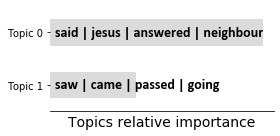

In [18]:
ax = df_.sum(axis=0).div(100).sort_values().plot.barh(color='lightgrey', alpha=0.8, figsize=(4, 2))

pos = np.arange(2)
ax.set_xticks([])
ax.set_xticklabels([])

for i, topic in enumerate(np.array(
    tfidf.get_feature_names())[H.argsort(axis=1)[::-1, :-5:-1]].tolist()):
    text = ' | '.join(topic)
    ax.annotate(s=text,
                xy=(0.2, pos[i]),
                fontsize=14, fontweight='bold', fontname='Calibri',
                va='center')

ax.spines['top'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.set_xlabel('Topics relative importance', fontsize=14)

plt.tight_layout()

This concludes our illustration of the text processing workflow. 

For an actual corpus of non-trivial size, the general workflow is similar. Typically we would also use lemmatisation (via [spaCy](https://spacy.io/) for instance) to reduce the words to their roots and we might add a few stopwords of our own based on the nature of our corpus.

Having described the general idea behind the TFIDF transformation and the use of NMF to extract topic models, we turn our attention to the decisions of the High Court of Australia.

# 2. High Court of Australia: Mabo &amp; Proximity


We've already described the corpus in [our previous article](http://www.unswlawjournal.unsw.edu.au/article/reading-the-high-court-at-a-distance-topic-modelling-the-legal-subject-matter-and-judicial-activity-of-the-high-court-of-australia-1903-2015/). The two main differences with our previous work is that we've extended the corpus to cover the period from 1903 to 2017, and we apply the TFIDF transformation to our corpus before training a topic model using NMF.

Below we analyse the resulting trained model.


## A. 10-topic model
#### Loading the model

Each row of the dataframe is indexed by the case ID (year and case number), and contains the (NMF) topic weights for the case, as well as a url where the text of the case can be found.

In [19]:
model = pd.read_csv('models/trained_model_10.csv', index_col=0)
model.head()

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,url
1903_1,0.000000,0.000000,0.000000,0.000000,0.097776,0.000000,0.000000,0.000000,0.0,0.000000,http://classic.austlii.edu.au/au/cases/cth/HCA...
1903_2,0.001134,0.000000,0.001915,0.007102,0.045932,0.000000,0.012782,0.011721,0.0,0.000000,http://classic.austlii.edu.au/au/cases/cth/HCA...
1903_3,0.006588,0.000000,0.000000,0.000000,0.050523,0.000000,0.000000,0.000000,0.0,0.000000,http://classic.austlii.edu.au/au/cases/cth/HCA...
1904_1,0.017752,0.000000,0.000000,0.000000,0.096593,0.000564,0.000000,0.000000,0.0,0.000000,http://classic.austlii.edu.au/au/cases/cth/HCA...
1904_2,0.000000,0.000821,0.000000,0.000000,0.027694,0.000000,0.000000,0.000000,0.0,0.001256,http://classic.austlii.edu.au/au/cases/cth/HCA...


#### Top 10 tokens for each topic

In [20]:
topics = pd.read_csv('models/topics_10.csv', index_col=0)
topics

,token0,token1,token2,token3,token4,token5,token6,token7,token8,token9
Topic,,,,,,,,,,
0,income,tax,taxpayer,assessment,commissioner,taxation,assessable,profit,deduction,taxable
1,jury,trial,accuse,verdict,criminal,applicant,witness,murder,complainant,police
2,award,industrial,dispute,arbitration,conciliation,employee,employer,union,organization,industry
3,land,lease,value,owner,crown,lessee,council,rent,title,property
4,constitution,jurisdiction,federal,parliament,applicant,tribunal,minister,regulation,government,judicial
5,estate,testator,child,trust,trustee,gift,property,death,deceased,wife
6,compensation,injury,worker,damage,employer,employment,negligence,accident,loss,incapacity
7,contract,agreement,purchaser,vendor,sale,money,purchase,price,payment,clause
8,company,share,shareholder,profit,capital,dividend,director,business,asset,value


#### Relative weight of the topics in the corpus

If we normalise the topic weights to sum to 1 for each judgement, we can assign an proportion of each judgement to each topic. By summing those fractions of a judgement we can get an effective number of judgement associated with each topic. 

By plotting this effective number of judgement we can get a sense of the relative importance of the topics within the corpus.

In [21]:
def get_topic_weights(model):

    arr = model.iloc[:, :-1].values.copy()
    arr /= arr.sum(axis=1, keepdims=True)

    return arr.sum(axis=0)

def plot_topic_relative_importance(model, topics, fontname='Calibri', fontsize=12, topn=8):

    with plt.style.context(('seaborn-white')):

        n_topics = topics.shape[0]

        pos = np.arange(n_topics)

        topic_weights = get_topic_weights(model)
        weights = topic_weights / model.iloc[:, :-1].values.sum()
        idx = np.argsort(weights)
                
        fig, ax = plt.subplots(figsize=(10, 0.6 * n_topics))
        
        ax.barh(pos, weights[idx], color='lightgray', alpha=0.8)
        ax.set_yticks(pos)
        ax.set_yticklabels([f"Topic {str(i)}" for i in idx], fontsize=fontsize, fontname=fontname)

        for i, topic in enumerate(idx):
            text = " | ".join(topics.iloc[topic, :topn].values.tolist())
            ax.annotate(s=text,
                        xy=(weights.max()/100, pos[i]),
                        fontsize=fontsize, fontweight='bold', fontname=fontname,
                        va='center')
            
        ax.spines['top'].set_color('none')
        ax.spines['left'].set_color('none')
        ax.spines['right'].set_color('none')

        ax.set_xlabel('Topics relative importance', fontsize=16, fontname=fontname)
        xlab = ax.get_xticklabels()
        ax.set_xticklabels(xlab, fontsize=fontsize)
        
        fig.tight_layout()
        
        return fig

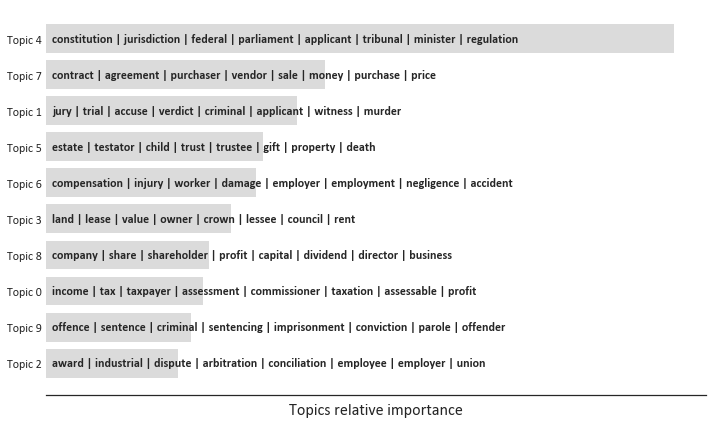

In [22]:
f = plot_topic_relative_importance(model, topics)
# f.savefig('relative_importance_10.png', dpi=96)

In the figure above, the importance of each topic, relative to the dominant one, is represented by a gray, horizontal bar. The top 8 tokens (vocabulary words) for each topic is overlaid on the bar.

### Topic composition

Let's identify the judgements for the Mabo litigation and those related to the concept of "proximity"  by their case IDs.

We can visualise the topical make up of a judgement as a bar chart.

For the sake of clarity, we label each topic by its dominant token only, and the weights are normalised to that of the dominant topic.

In [23]:
mabo_cases      = ['1986_8', '1988_69', '1992_23']
proximity_cases = ['1984_52','1985_41','1986_1','1986_68','1991_18','1994_13','1997_9',
                   '1998_3','1999_36','2001_59','2008_40','2011_9']

In [24]:
def plot_topic_weights(model, topics, selection):
    N = len(selection)
    n_topics = model.shape[1] - 1

    fig, axes = plt.subplots(ncols=N, nrows=1, figsize=(N*1.5, n_topics//3), sharey=True, sharex=True)
    for i, case in enumerate(selection):
        val = model.drop('url', axis=1).loc[case, :]
        val = val/val.max()
        axes[i].barh(y=np.arange(n_topics), width=val, color='r', edgecolor='k', alpha=0.8, label=str(i))
        axes[i].set_yticks(np.arange(n_topics));
        title = case
        axes[i].set_yticklabels(topics.token0.str.title(), fontsize=14, fontname='Calibri',va='center')
        axes[i].set_title(title, fontname='Calibri', fontsize=15)
        
    fig.text((N+0.8)/N * 0.5, -0.02, 'relative topic weight', ha='center', fontname='Calibri', fontsize=18)
    fig.tight_layout()
    return fig

#### Mabo cases

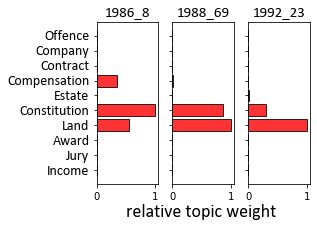

In [25]:
fig1 = plot_topic_weights(model, topics, mabo_cases)
# fig1.savefig('mabo_10.png', dpi=96, bbox_inches="tight")

#### Proximity cases

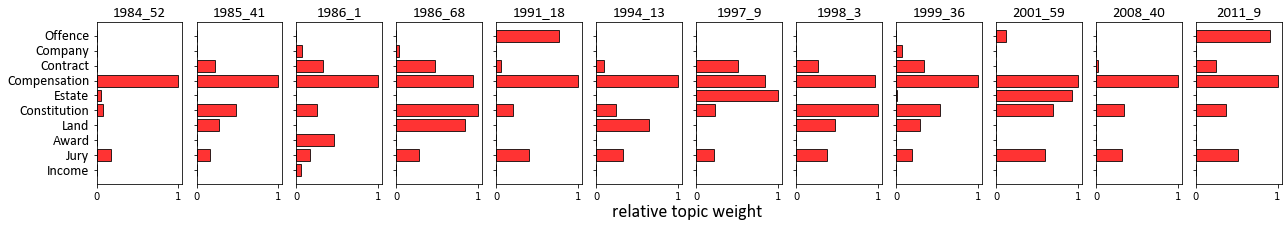

In [26]:
fig2 = plot_topic_weights(model, topics, proximity_cases)
# fig2.savefig('proximity_10.png', dpi=96, bbox_inches="tight")

We can also load the H matrix for this model. Recall that this matrix, which has as many rows as there are topics, and as many columns as there are tokens (words) in our vocabulary, tells us what words best describe each topic.

In [27]:
H = np.load('models/H_10.npz')['arr_0']
H.shape

(10, 29117)

### Hierarchical clustering of the topics

Whereas judgements can be compared by looking at their associated topic weights, topics themselves can also be compared by looking at their language similarities, that is the weights associated with the words of the vocabulary.

Let's do that visually first by plotting the cosine distance between the topics as a heatmap. 

We also plot a dendrogram of the topics, which allows us to see the topic hierarchy by showing us at what distance threshold topics become clustered together.

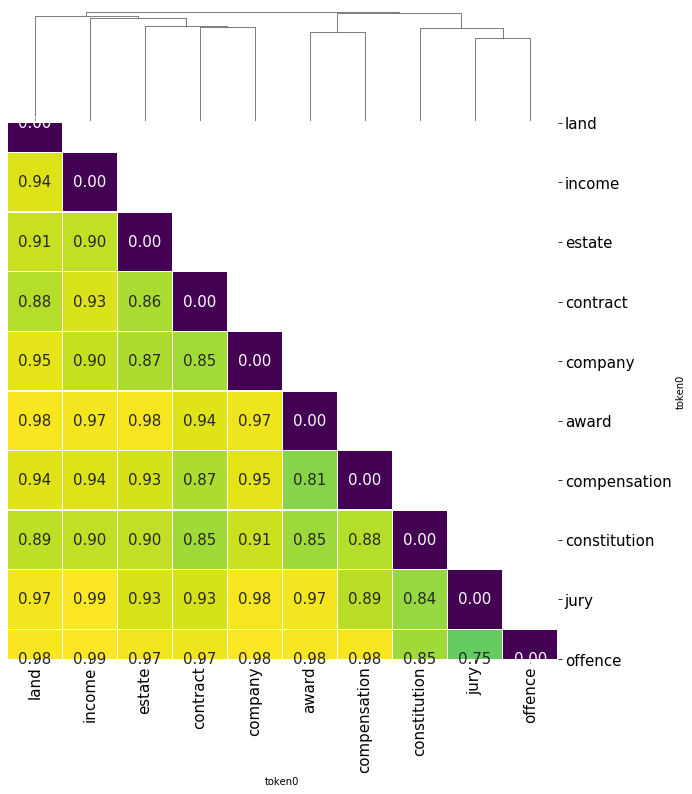

In [28]:
metric = 'cosine'
method = 'complete'
cmap = 'viridis'

labels = topics.token0

n_topics = H.shape[1]

# compute the pairwise cosine distance between the topics
dmat = pairwise_distances(H, metric=metric, n_jobs=-1)
Z = linkage(H, method, metric=metric)

# run a dummy clustermap to figure out the reordered indices
ctmp = sns.clustermap(pd.DataFrame(dmat, 
                                   index=labels, 
                                   columns=labels),
                      row_linkage=Z, 
                      col_linkage=Z, 
                      cmap=cmap, 
                      linewidths=0.5,
                      figsize=(0.1, 0.1),
                      annot=False)

ctmp.ax_heatmap.set_visible(False)
ctmp.ax_row_dendrogram.set_visible(False)
ctmp.ax_col_dendrogram.set_visible(False)
ctmp.cax.set_visible(False)

rows = np.array(ctmp.dendrogram_row.reordered_ind)
cols = np.array(ctmp.dendrogram_col.reordered_ind)

# create a mapping to keep track of which indices are above the diagonal
mapping = {i:j for i, j in zip(range(n_topics), rows)}

# Generate a mask for the upper triangle
mask = np.zeros_like(dmat, dtype=np.bool)
a, b = np.triu_indices_from(mask, k=1)
mask[[mapping[_] for _ in a], [mapping[_] for _ in b]] = True

# plot the final heatmap
cm = sns.clustermap(pd.DataFrame(dmat, 
                                 index=labels, 
                                 columns=labels),
                    row_linkage=Z, 
                    col_linkage=Z, 
                    cmap=cmap, 
                    linewidths=0.5,
                    figsize=(12, 12),
                    annot=True, 
                    annot_kws={"size": 15}, 
                    fmt='0.2f', mask=mask,
                    cbar_kws={'label':f'distance'})

# hide the colorbar
cm.cax.set_visible(False)

# modify the axes labels
plt.setp(cm.ax_heatmap.xaxis.get_majorticklabels(), rotation=90, fontsize=15)
plt.setp(cm.ax_heatmap.yaxis.get_majorticklabels(), rotation=0, fontsize=15)

# hide left dendrogram
cm.ax_row_dendrogram.set_visible(False)


Note that cosine distance is bounded between 0 (identical topics) and 1 (topics that are far apart).
The large distances seen in the heatmap (also visible on the dendrogram) are the consequence of the large dimensionality of the problem. Our vocabulary has more than 29,000 tokens, hence our topics are represented by points in a very high-dimensional space. In a high-dimensional space, even nearest neighbours are far apart. This is sometimes referred to as the "curse of dimensionality". We can still use the computed distance to extract a topic hierarchy, however. In fact, the resulting hierarchy is consistent with traditional legal analysis of Australian law (see the paper for the discussion).

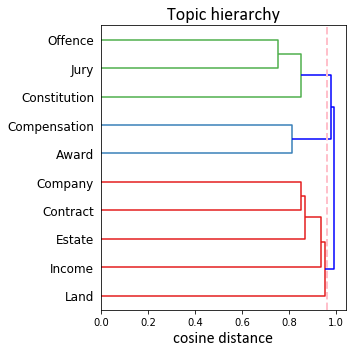

In [29]:
def plot_dendrogram(H, topics, threshold):
    
    linked = linkage(H, 'complete', metric='cosine')

    n_topics = H.shape[0]
    
    pal_name = 'Set1' if n_topics < 11 else 'tab20'

    palette = sns.color_palette(pal_name, n_colors=n_topics)

    set_link_color_palette([mpl.colors.rgb2hex(_) for _ in palette])
    
    fig, ax = plt.subplots(figsize=(5, H.shape[0]//2))  
        
    dendrogram(linked, ax=ax,
                color_threshold=threshold,
                labels = topics.token0.str.title().values,
                orientation='right',
                distance_sort='descending')
    
    plt.axvline(x=threshold, linewidth=2, color='pink', linestyle='--')
    
    ax.set_xlabel('cosine distance', fontsize=16, fontname='Calibri')
    ax.set_title('Topic hierarchy', fontsize=18, fontname='Calibri')

    fig.tight_layout()
    
    return fig

fig3 = plot_dendrogram(H, topics, threshold=0.96)
fig3.savefig('dendrogram_10.png', dpi=96)

The threshold parameter (represented by the vertical dashed line in the figure) denotes the distance below which topics are clustered together. 

Starting from the left (distance of 0), each topic (represented by a horizontal line) is its own cluster. 
As we increase the distance threshold (as we move to right), topics will start to merge into clusters.
For instance, the first two topics to merge are "Offence" and "Jury". This means that out of the 10 topics these two are the most similar in terms of their vocabulary words weights in the NMF decomposition.

As we move to the right on the figure, the next two topics to form a cluster are "Compensation" and "Award".

Then "Constitution" gets added to the first cluster, etc...

We see in the figure above that, _given the chosen distance threshold_ a decomposition of our topics into 3 clusters emerge.

Note that we don't have to plot the dendrogram to cluster our topics, we can use a hierarchical clustering technique directly to tease out the similarity between the topics.

Let's create a helper function to do just that.

In [30]:
def cluster_topics(H, topics, n_clusters=3):
    cluster = AgglomerativeClustering(n_clusters=n_clusters, 
                                      affinity='cosine', 
                                      linkage='complete')  
    
    df_clust = (pd.DataFrame({'topic': topics.token0, 
                              'cluster': cluster.fit_predict(H)})
                    .reset_index(drop=True)
                    .groupby('cluster')
                    .agg(lambda x: tuple(x))
               )
    print(f"\n{'='*80}\nClustering topics into {n_clusters} clusters:")
    with pd.option_context('display.max_colwidth', 200):
        display(df_clust)

We can now cluster our topics into an arbitrary number of clusters.

In [31]:
for N in range(2, 7):
    cluster_topics(H, topics, N)


Clustering topics into 2 clusters:


,topic
cluster,
0,"(jury, award, constitution, compensation, offence)"
1,"(income, land, estate, contract, company)"



Clustering topics into 3 clusters:


,topic
cluster,
0,"(income, land, estate, contract, company)"
1,"(jury, constitution, offence)"
2,"(award, compensation)"



Clustering topics into 4 clusters:


,topic
cluster,
0,"(income, estate, contract, company)"
1,"(jury, constitution, offence)"
2,"(award, compensation)"
3,"(land,)"



Clustering topics into 5 clusters:


,topic
cluster,
0,"(estate, contract, company)"
1,"(jury, constitution, offence)"
2,"(award, compensation)"
3,"(land,)"
4,"(income,)"



Clustering topics into 6 clusters:


,topic
cluster,
0,"(contract, company)"
1,"(jury, constitution, offence)"
2,"(award, compensation)"
3,"(land,)"
4,"(income,)"
5,"(estate,)"


The case of 3 clusters corresponds to the one we plotted the dendrogram for.

### Dimensionality reduction: UMAP projection

Coming back to the judgements themselves, the bar charts above are helpful in determining the topical make up of a judgement, they are also useful when comparing a few judgements. However, they do not tell us anything regarding how the judgements fit (from a topical perspective) within the overall High Court corpus.

Ideally, we'd like to visualise the topic weights for all the judgements at once, draw a topical portrait of the High Court judgements as it were. This is of course not possible with 10 topics as, mathematically speaking, each judgement corresponds to a point in a 10 dimensional space.

We can, however, use dimensionality reduction techniques to project the judgement on a 2 dimensional space, thus allowing us to visualise the corpus. 

Many dimensionality reduction techniques exist but for our purpose we found that the wonderful [Uniform Manifold Approximation and Projection (UMAP)](https://github.com/lmcinnes/umap) method works best.

In [32]:
embedding = UMAP(n_neighbors=100, 
                 min_dist=1, 
                 metric='euclidean', 
                 random_state=0, 
                 verbose=False)

Wproj = embedding.fit_transform(model.iloc[:, :-1])

We create a helper function that will allow us to visualise the topic distribution across the corpus:

- Each point in the resulting scatter plot corresponds to a judgement of the High Court. 

- For each judgement the colour corresponds to its _dominant_ topic. 

- The size and opacity of a point are proportional to its topical "purity". 

In other words, a judgement that is associated with a single topic will be represented by a large, opaque dot, whereas a judgement that is composed of several topics will be represented by a smaller, more transparent dot.

In [33]:
def plot_embedding(model, Wproj, topics, fontname='Calibri'):

    # get indices for Mabo and proximity cases
    mabo_idx = np.where(model.index.isin(mabo_cases))[0]
    prox_idx = np.where(model.index.isin(proximity_cases))[0]

    # get top topic for each case
    W = model.iloc[:, :-1].values
    top_topic = np.argsort(W, axis=1)[:, -1]
    n_topics = topics.shape[1]

    # define colour palette
    pal_name = 'Paired' if n_topics < 11 else 'tab20'
    palette = np.array(sns.color_palette(pal_name, n_colors=W.shape[1]))
    colors = palette[top_topic]

    # Use alpha channel to denote how dominant the main topic is.
    # If a case has all its weight in a single topic then alpha will be 1.
    # If the case is a mixture of many topics alpha will be closer to 0.
    alphas = np.sort(W)[:, -1].reshape(-1, 1)
    alphas = alphas/alphas.max()
    colors = np.hstack((colors, alphas))

    # create the figure
    fig, ax = plt.subplots(figsize=(14, 10))

    # basic scatter plot
    ax.scatter(Wproj[:, 0], Wproj[:, 1], 
               s=200 * alphas, 
               edgecolors='k', 
               linewidths=0.2, 
               color=colors)

    # We need to label the individual dominant topics separately.
    for t in range(W.shape[1]):
        idx = np.argmax(top_topic == t)
        ax.scatter(Wproj[idx, 0], 
                   Wproj[idx, 1], 
                   s=0.01, 
                   alpha=1, 
                   edgecolors='k', 
                   color=colors[idx], 
                   label=topics.iloc[t, 0].title().strip())

    # Highlight the Mabo and proximity cases.
    ax.scatter(Wproj[mabo_idx, 0], 
               Wproj[mabo_idx, 1], 
               s=400, 
               marker='*', 
               edgecolors='k', 
               linewidths=1, 
               alpha=1, 
               color=colors[mabo_idx])
    
    ax.scatter(Wproj[prox_idx, 0],
               Wproj[prox_idx, 1], 
               s=150, marker='s', 
               edgecolors='k', 
               linewidths=1, 
               alpha=1, 
               color=colors[prox_idx])

    # Link the Mabo cases with arrows in chronological order
    mabo_pairs = [(a, b) for a, b in zip(mabo_idx, mabo_idx[1:])]
    
    for idx1, idx2 in mabo_pairs:

        x1, y1 = Wproj[idx1, 0], Wproj[idx1, 1]
        x2, y2 = Wproj[idx2, 0], Wproj[idx2, 1]

        ann = ax.annotate("",
                          xy=(x2, y2), 
                          xycoords='data',
                          xytext=(x1, y1), 
                          textcoords='data',
                          size=30, 
                          va="center", 
                          ha="center",
                          bbox=dict(boxstyle="round4", fc="w"),
                          arrowprops=dict(arrowstyle="-|>",
                                      connectionstyle="arc3,rad=0.3",
                                      fc="w"), 
                          )

    # Annotate the Mabo cases
    path_effects = [PathEffects.withStroke(linewidth=3, foreground="w")]

    for i, idx in enumerate(mabo_idx):
        ax.annotate(s=f"{mabo_cases[i]}    ", 
                    ha="right",
                    xy=(Wproj[idx, 0], Wproj[idx, 1]), 
                    fontname=fontname, 
                    color='k',
                    path_effects=path_effects,
                    fontsize=16)

    # Plot the legend
    leg = ax.legend(bbox_to_anchor = (1, 1), 
                    markerscale=150, 
                    frameon=False, 
                    handletextpad=0,
                    prop={"family":fontname, "size":18}) 

    # set the aspect ratio
    ax.set_aspect(0.9)
    
    # Remove the axes
    ax.axes.axis('off')

    fig.tight_layout()
    
    return fig


We can now plot the UMAP representation of the 10-topic model of the High Court corpus.

We also highlight the Mabo and proximity cases (see the paper for the associated discussion).

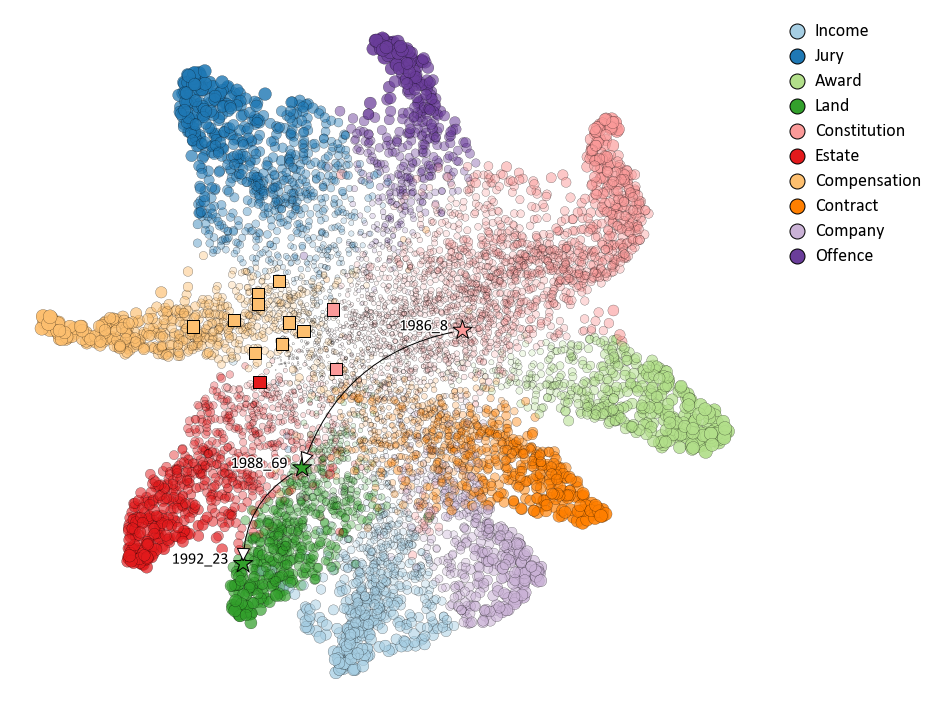

In [34]:
fig4 = plot_embedding(model, Wproj, topics)
# fig4.savefig('projection_10_topics.png', dpi=96)

## B. 20 topic model

The same type of analysis can be conducted on a 20-topic model.

We present the results below and refer the interested reader to our paper for the corresponding discussion.

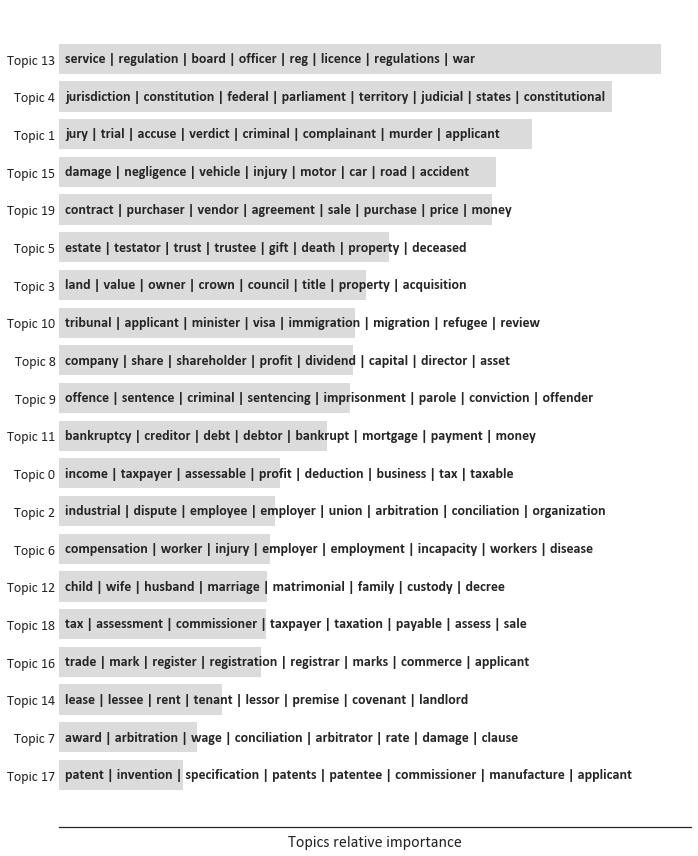

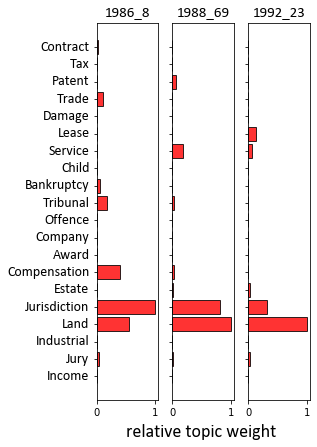

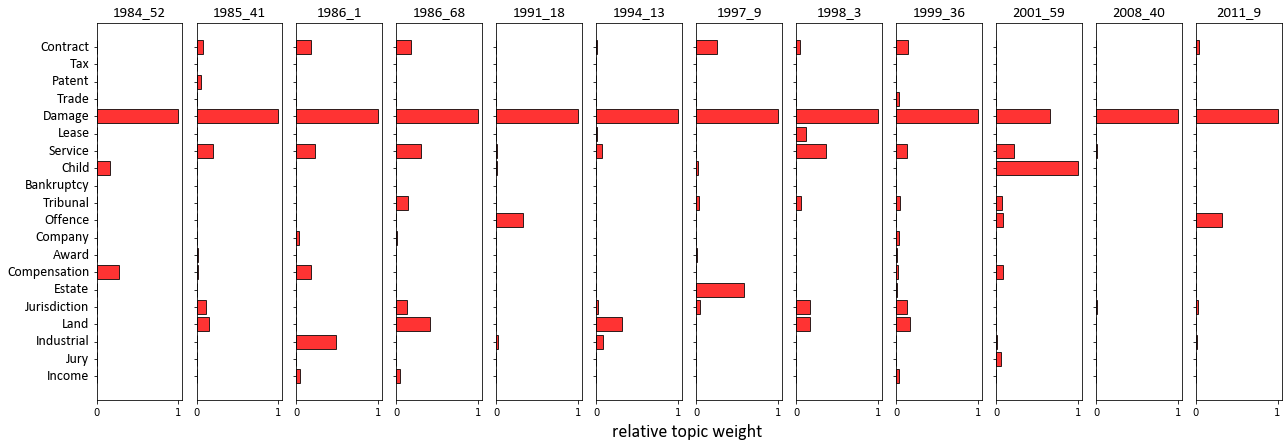

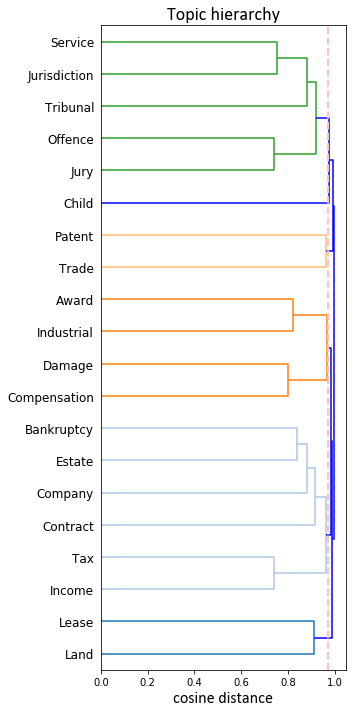

In [35]:
model_20 = pd.read_csv('models/trained_model_20.csv', index_col=0)
topics_20 = pd.read_csv('models/topics_20.csv', index_col=0)

H_20 = np.load('models/H_20.npz')['arr_0']

f = plot_topic_relative_importance(model_20, topics_20, fontsize=14)
# f.savefig('relative_importance_20.png', dpi=96)

fig5 = plot_topic_weights(model_20, topics_20, mabo_cases)
fig6 = plot_topic_weights(model_20, topics_20, proximity_cases)
fig7 = plot_dendrogram(H_20, topics_20, threshold=0.97)

In [36]:
for N in range(2, 11):
    cluster_topics(H_20, topics_20, N)


Clustering topics into 2 clusters:


,topic
cluster,
0,"(jury, jurisdiction, offence, tribunal, child, service, trade, patent)"
1,"(income, industrial, land, estate, compensation, award, company, bankruptcy, lease, damage, tax, contract)"



Clustering topics into 3 clusters:


,topic
cluster,
0,"(income, industrial, land, estate, compensation, award, company, bankruptcy, lease, damage, tax, contract)"
1,"(jury, jurisdiction, offence, tribunal, child, service)"
2,"(trade, patent)"



Clustering topics into 4 clusters:


,topic
cluster,
0,"(income, industrial, estate, compensation, award, company, bankruptcy, damage, tax, contract)"
1,"(jury, jurisdiction, offence, tribunal, child, service)"
2,"(trade, patent)"
3,"(land, lease)"



Clustering topics into 5 clusters:


,topic
cluster,
0,"(jury, jurisdiction, offence, tribunal, child, service)"
1,"(industrial, compensation, award, damage)"
2,"(trade, patent)"
3,"(land, lease)"
4,"(income, estate, company, bankruptcy, tax, contract)"



Clustering topics into 6 clusters:


,topic
cluster,
0,"(industrial, compensation, award, damage)"
1,"(income, estate, company, bankruptcy, tax, contract)"
2,"(trade, patent)"
3,"(land, lease)"
4,"(jury, jurisdiction, offence, tribunal, service)"
5,"(child,)"



Clustering topics into 7 clusters:


,topic
cluster,
0,"(trade, patent)"
1,"(income, estate, company, bankruptcy, tax, contract)"
2,"(industrial, award)"
3,"(land, lease)"
4,"(jury, jurisdiction, offence, tribunal, service)"
5,"(child,)"
6,"(compensation, damage)"



Clustering topics into 8 clusters:


,topic
cluster,
0,"(income, estate, company, bankruptcy, tax, contract)"
1,"(jury, jurisdiction, offence, tribunal, service)"
2,"(industrial, award)"
3,"(land, lease)"
4,"(patent,)"
5,"(child,)"
6,"(compensation, damage)"
7,"(trade,)"



Clustering topics into 9 clusters:


,topic
cluster,
0,"(jury, jurisdiction, offence, tribunal, service)"
1,"(estate, company, bankruptcy, contract)"
2,"(industrial, award)"
3,"(land, lease)"
4,"(patent,)"
5,"(child,)"
6,"(compensation, damage)"
7,"(trade,)"
8,"(income, tax)"



Clustering topics into 10 clusters:


,topic
cluster,
0,"(estate, company, bankruptcy, contract)"
1,"(land, lease)"
2,"(industrial, award)"
3,"(jurisdiction, tribunal, service)"
4,"(jury, offence)"
5,"(child,)"
6,"(compensation, damage)"
7,"(trade,)"
8,"(income, tax)"


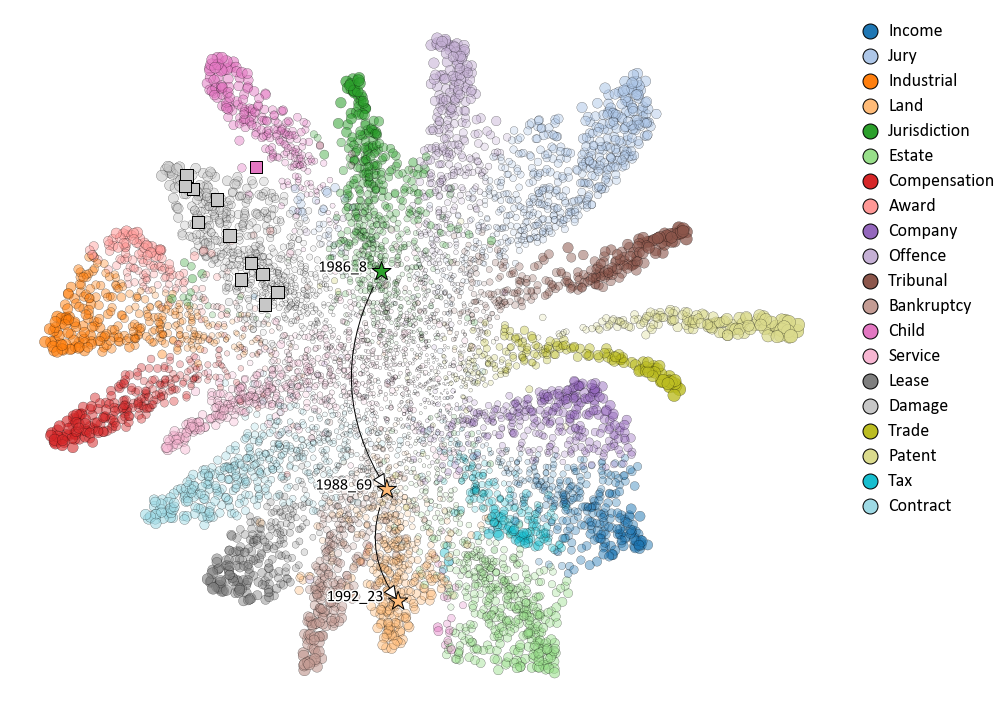

In [37]:
embedding = UMAP(n_neighbors=100, 
                 min_dist=1, 
                 metric='euclidean', 
                 random_state=0, 
                 verbose=False)

Wproj_20 = embedding.fit_transform(model_20.iloc[:, :-1])
fig8 = plot_embedding(model_20, Wproj_20, topics_20)
# fig8.savefig('projection_20_topics.png', dpi=96)

## Appendix: A note on the number of topics

The choice of the number of topics is somewhat arbitrary. A small number of topics gives a simple account
of the court's work, whereas a larger number of topics can provide a more nuanced view, at the expense of greater complexity. 

In our application to law, the algorithm is subservient to human expertise, and the computation is only useful insofar as it allows a legal expert to formulate conclusions that are consistent with traditional legal analysis.
In this context, it is up to the human expert to experiment with the number of topics to find a suitable level of granularity, a suitable "distance" at which one would might the corpus.

In other (quantitative) disciplines, however, the hierarchy is often reversed and an automated method 
of choosing the number of topics might be preferred to having to rely on human judgement. A common way to do this is via a coherence measure, a score of how "good" the topic model (according to some criterion), which is similar to how the optimal number of clusters is chosen in a clustering algorithm.

If we compute a coherence score for our corpus (using the UMass metric, see for instance https://aclweb.org/anthology/D12-1087 and https://radimrehurek.com/gensim/models/coherencemodel.html for more information), we find that a model with 15 topics has the highest coherence score among models ranging from 5 to 25 topics. 

The corresponding results are shown below. As far as our discussion of the Mabo litigations and the proximity cases are concerned, this model provides the same insights into the Mabo and proximity cases as the 10 and 20 topic models.

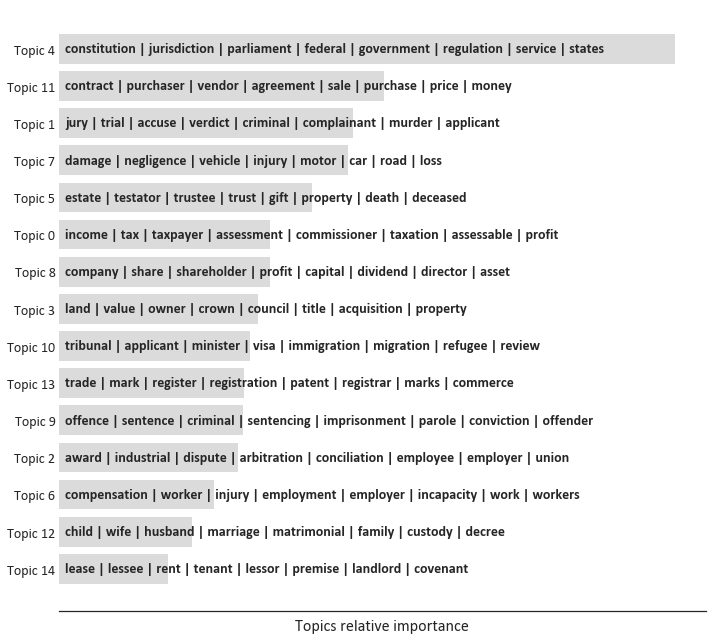

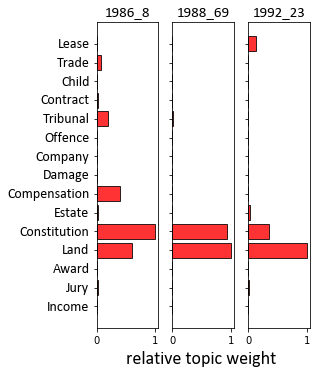

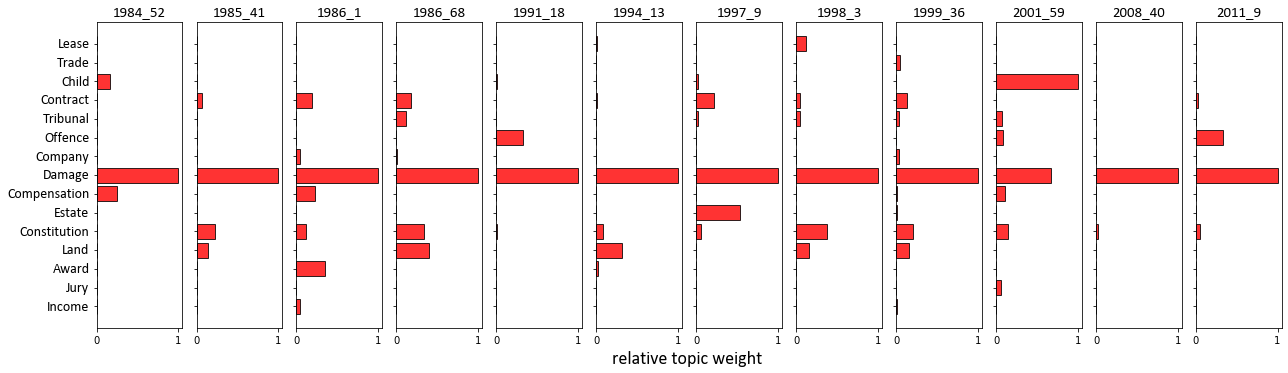

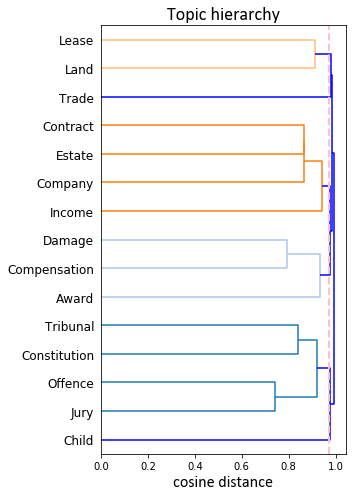

In [43]:
model_15 = pd.read_csv('models/trained_model_15.csv', index_col=0)
topics_15 = pd.read_csv('models/topics_15.csv', index_col=0)

H_15 = np.load('models/H_15.npz')['arr_0']

_ = plot_topic_relative_importance(model_15, topics_15, fontsize=14)

_ = plot_topic_weights(model_15, topics_15, mabo_cases)
_ = plot_topic_weights(model_15, topics_15, proximity_cases)
_ = plot_dendrogram(H_15, topics_15, threshold=0.97)

In [44]:
for N in range(2, 11):
    cluster_topics(H_15, topics_15, N)


Clustering topics into 2 clusters:


,topic
cluster,
0,"(income, award, land, estate, compensation, damage, company, contract, trade, lease)"
1,"(jury, constitution, offence, tribunal, child)"



Clustering topics into 3 clusters:


,topic
cluster,
0,"(land, trade, lease)"
1,"(jury, constitution, offence, tribunal, child)"
2,"(income, award, estate, compensation, damage, company, contract)"



Clustering topics into 4 clusters:


,topic
cluster,
0,"(income, award, estate, compensation, damage, company, contract)"
1,"(jury, constitution, offence, tribunal, child)"
2,"(land, lease)"
3,"(trade,)"



Clustering topics into 5 clusters:


,topic
cluster,
0,"(jury, constitution, offence, tribunal, child)"
1,"(income, estate, company, contract)"
2,"(land, lease)"
3,"(trade,)"
4,"(award, compensation, damage)"



Clustering topics into 6 clusters:


,topic
cluster,
0,"(income, estate, company, contract)"
1,"(award, compensation, damage)"
2,"(land, lease)"
3,"(trade,)"
4,"(jury, constitution, offence, tribunal)"
5,"(child,)"



Clustering topics into 7 clusters:


,topic
cluster,
0,"(award, compensation, damage)"
1,"(jury, constitution, offence, tribunal)"
2,"(land, lease)"
3,"(trade,)"
4,"(estate, company, contract)"
5,"(child,)"
6,"(income,)"



Clustering topics into 8 clusters:


,topic
cluster,
0,"(jury, constitution, offence, tribunal)"
1,"(estate, company, contract)"
2,"(land, lease)"
3,"(trade,)"
4,"(compensation, damage)"
5,"(child,)"
6,"(income,)"
7,"(award,)"



Clustering topics into 9 clusters:


,topic
cluster,
0,"(land, lease)"
1,"(estate, company, contract)"
2,"(constitution, tribunal)"
3,"(jury, offence)"
4,"(compensation, damage)"
5,"(child,)"
6,"(income,)"
7,"(award,)"
8,"(trade,)"



Clustering topics into 10 clusters:


,topic
cluster,
0,"(estate, company, contract)"
1,"(compensation, damage)"
2,"(constitution, tribunal)"
3,"(jury, offence)"
4,"(lease,)"
5,"(child,)"
6,"(income,)"
7,"(award,)"
8,"(trade,)"


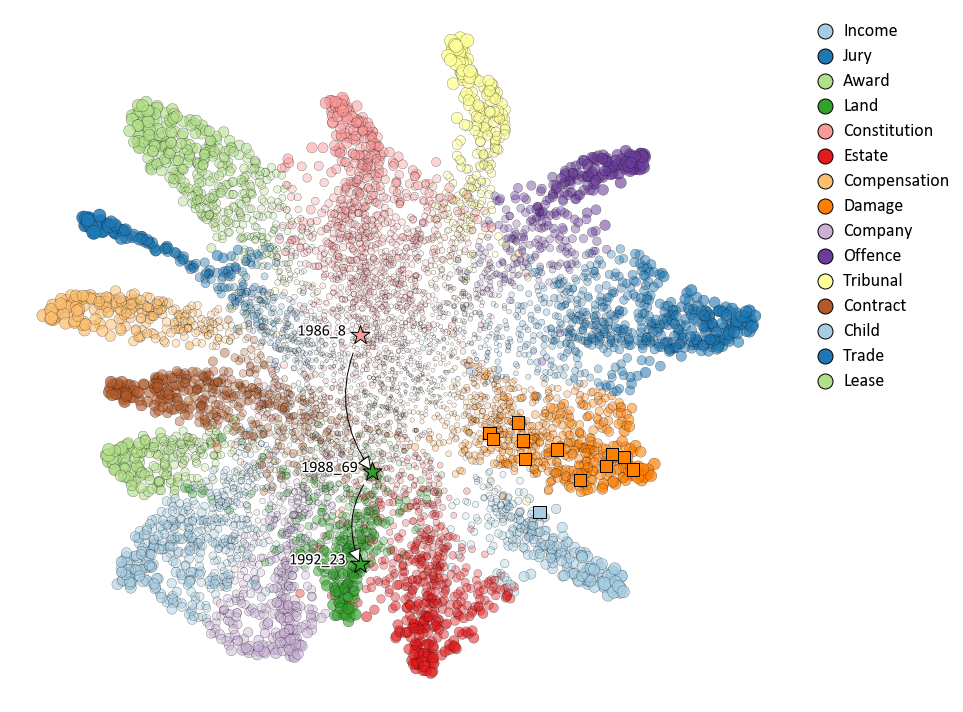

In [45]:
embedding = UMAP(n_neighbors=100, 
                 min_dist=1, 
                 metric='euclidean', 
                 random_state=0, 
                 verbose=False)

Wproj_15 = embedding.fit_transform(model_15.iloc[:, :-1])
_ = plot_embedding(model_15, Wproj_15, topics_15)

----
Copyright &copy; 2019 <a href="https://twitter.com/dinkumdata">Adel Rahmani</a>. 

The text is released under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>, and the code is released under the <a href="https://opensource.org/licenses/MIT">MIT license</a>.